# Social Vulnerability Data

## Quick EDA and Modeling to Determine What Features Stick Out for Importance

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

In [2]:
df = pd.read_csv('../data/social_vulnerability/SVI2020_US.csv')

In [3]:
df.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,1,Alabama,AL,1001,Autauga,1001020100,"Census Tract 201, Autauga County, Alabama",3.793570,1941,390,...,2.1,2.7,0.0,1.8,0.0,1.8,6.6,5.1,0.0,1.8
1,1,Alabama,AL,1001,Autauga,1001020200,"Census Tract 202, Autauga County, Alabama",1.282174,1757,310,...,0.0,2.0,0.0,2.0,0.0,2.0,2.6,3.0,0.8,1.1
2,1,Alabama,AL,1001,Autauga,1001020300,"Census Tract 203, Autauga County, Alabama",2.065364,3694,570,...,1.2,1.1,0.0,0.9,0.0,0.9,1.8,2.3,0.0,0.9
3,1,Alabama,AL,1001,Autauga,1001020400,"Census Tract 204, Autauga County, Alabama",2.464984,3539,500,...,0.5,0.6,0.3,0.5,0.0,1.0,2.9,2.8,0.0,1.0
4,1,Alabama,AL,1001,Autauga,1001020501,"Census Tract 205.01, Autauga County, Alabama",2.395243,4306,662,...,1.9,2.0,0.0,0.8,0.0,0.8,0.3,0.6,0.0,0.8


In [10]:
!pip install -U pandas

     --------------------------------------- 10.7/10.7 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4


In [4]:
print(pd.__version__)

2.0.2


In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84122 entries, 0 to 84121
Data columns (total 158 columns):
 #    Column        Dtype  
---   ------        -----  
 0    ST            int64  
 1    STATE         object 
 2    ST_ABBR       object 
 3    STCNTY        int64  
 4    COUNTY        object 
 5    FIPS          int64  
 6    LOCATION      object 
 7    AREA_SQMI     float64
 8    E_TOTPOP      int64  
 9    M_TOTPOP      int64  
 10   E_HU          int64  
 11   M_HU          int64  
 12   E_HH          int64  
 13   M_HH          int64  
 14   E_POV150      int64  
 15   M_POV150      int64  
 16   E_UNEMP       int64  
 17   M_UNEMP       int64  
 18   E_HBURD       int64  
 19   M_HBURD       int64  
 20   E_NOHSDP      int64  
 21   M_NOHSDP      int64  
 22   E_UNINSUR     int64  
 23   M_UNINSUR     int64  
 24   E_AGE65       int64  
 25   M_AGE65       int64  
 26   E_AGE17       int64  
 27   M_AGE17       int64  
 28   E_DISABL      int64  
 29   M_DISABL      in

In [9]:
df.isna().sum()

ST              0
STATE           0
ST_ABBR         0
STCNTY          0
COUNTY          0
               ..
MP_NHPI         0
EP_TWOMORE      0
MP_TWOMORE      0
EP_OTHERRACE    0
MP_OTHERRACE    0
Length: 158, dtype: int64

#### This is the overall SVI index variable, and will be our Y variable.

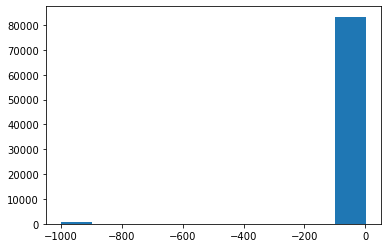

In [23]:
plt.hist(df['RPL_THEMES']);

> This hist was weird, since all values should be between 0 and 1. Since this looked weird, I looked into the reason further.

In [22]:
df['RPL_THEMES'].sort_values()

49642   -999.0
40669   -999.0
11661   -999.0
40670   -999.0
66139   -999.0
         ...  
72419      1.0
79752      1.0
81863      1.0
76756      1.0
20040      1.0
Name: RPL_THEMES, Length: 84122, dtype: float64

The -999.0 value is not a real value. According to the data dictionary:
- Tracts with zero estimates for total population (N = 645 for the U.S.) were removed during the ranking process. These tracts were added back to the SVI databases after ranking. The TOTPOP field value is 0, but the percentile ranking fields (RPL_THEME1, RPL_THEME2, RPL_THEME3, RPL_THEME4, and RPL_THEMES) were set to -999. 
- For tracts with - 0 TOTPOP, a value of -999 in any field either means the value was unavailable from the original census data or we could not calculate a derived value because of unavailable census data. 
- Any cells with a -999 were not used for further calculations. For example, total flags do not include fields with a -999 value. 

In [27]:
df = df[df['RPL_THEMES']!=-999.0]
df

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,1,Alabama,AL,1001,Autauga,1001020100,"Census Tract 201, Autauga County, Alabama",3.793570,1941,390,...,2.1,2.7,0.0,1.8,0.0,1.8,6.6,5.1,0.0,1.8
1,1,Alabama,AL,1001,Autauga,1001020200,"Census Tract 202, Autauga County, Alabama",1.282174,1757,310,...,0.0,2.0,0.0,2.0,0.0,2.0,2.6,3.0,0.8,1.1
2,1,Alabama,AL,1001,Autauga,1001020300,"Census Tract 203, Autauga County, Alabama",2.065364,3694,570,...,1.2,1.1,0.0,0.9,0.0,0.9,1.8,2.3,0.0,0.9
3,1,Alabama,AL,1001,Autauga,1001020400,"Census Tract 204, Autauga County, Alabama",2.464984,3539,500,...,0.5,0.6,0.3,0.5,0.0,1.0,2.9,2.8,0.0,1.0
4,1,Alabama,AL,1001,Autauga,1001020501,"Census Tract 205.01, Autauga County, Alabama",2.395243,4306,662,...,1.9,2.0,0.0,0.8,0.0,0.8,0.3,0.6,0.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84117,56,Wyoming,WY,56043,Washakie,56043000200,"Census Tract 2, Washakie County, Wyoming",2231.951436,3124,198,...,0.0,1.1,0.1,0.1,0.0,1.1,1.6,1.8,0.0,1.1
84118,56,Wyoming,WY,56043,Washakie,56043000301,"Census Tract 3.01, Washakie County, Wyoming",0.769579,2231,273,...,0.0,1.6,0.1,0.3,0.0,1.6,5.6,3.8,1.4,1.5
84119,56,Wyoming,WY,56043,Washakie,56043000302,"Census Tract 3.02, Washakie County, Wyoming",5.957251,2578,314,...,0.0,1.3,0.9,1.2,0.0,1.3,2.9,3.5,0.0,1.3
84120,56,Wyoming,WY,56045,Weston,56045951100,"Census Tract 9511, Weston County, Wyoming",2355.222335,3276,280,...,2.0,2.8,0.1,0.1,0.0,1.1,6.1,4.1,0.0,1.1


> Removing the rows for the column 'RPL_THEMES' with a value of -999.0. These will not be used for modeling.

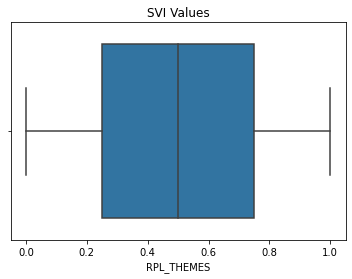

In [100]:
sns.boxplot(x=df['RPL_THEMES']).set_title('SVI Values');

> The majority of values are between 0.2 and 0.8.

In [60]:
df.columns

Index(['ST', 'STATE', 'ST_ABBR', 'STCNTY', 'COUNTY', 'FIPS', 'LOCATION',
       'AREA_SQMI', 'E_TOTPOP', 'M_TOTPOP',
       ...
       'EP_ASIAN', 'MP_ASIAN', 'EP_AIAN', 'MP_AIAN', 'EP_NHPI', 'MP_NHPI',
       'EP_TWOMORE', 'MP_TWOMORE', 'EP_OTHERRACE', 'MP_OTHERRACE'],
      dtype='object', length=158)

In [63]:
# isolating all numerical columns
df.columns.drop(labels=['STATE','ST_ABBR','COUNTY','LOCATION']).to_list()

['ST',
 'STCNTY',
 'FIPS',
 'AREA_SQMI',
 'E_TOTPOP',
 'M_TOTPOP',
 'E_HU',
 'M_HU',
 'E_HH',
 'M_HH',
 'E_POV150',
 'M_POV150',
 'E_UNEMP',
 'M_UNEMP',
 'E_HBURD',
 'M_HBURD',
 'E_NOHSDP',
 'M_NOHSDP',
 'E_UNINSUR',
 'M_UNINSUR',
 'E_AGE65',
 'M_AGE65',
 'E_AGE17',
 'M_AGE17',
 'E_DISABL',
 'M_DISABL',
 'E_SNGPNT',
 'M_SNGPNT',
 'E_LIMENG',
 'M_LIMENG',
 'E_MINRTY',
 'M_MINRTY',
 'E_MUNIT',
 'M_MUNIT',
 'E_MOBILE',
 'M_MOBILE',
 'E_CROWD',
 'M_CROWD',
 'E_NOVEH',
 'M_NOVEH',
 'E_GROUPQ',
 'M_GROUPQ',
 'EP_POV150',
 'MP_POV150',
 'EP_UNEMP',
 'MP_UNEMP',
 'EP_HBURD',
 'MP_HBURD',
 'EP_NOHSDP',
 'MP_NOHSDP',
 'EP_UNINSUR',
 'MP_UNINSUR',
 'EP_AGE65',
 'MP_AGE65',
 'EP_AGE17',
 'MP_AGE17',
 'EP_DISABL',
 'MP_DISABL',
 'EP_SNGPNT',
 'MP_SNGPNT',
 'EP_LIMENG',
 'MP_LIMENG',
 'EP_MINRTY',
 'MP_MINRTY',
 'EP_MUNIT',
 'MP_MUNIT',
 'EP_MOBILE',
 'MP_MOBILE',
 'EP_CROWD',
 'MP_CROWD',
 'EP_NOVEH',
 'MP_NOVEH',
 'EP_GROUPQ',
 'MP_GROUPQ',
 'EPL_POV150',
 'EPL_UNEMP',
 'EPL_HBURD',
 'EPL_NOHSDP',

#### Isolating object columns

In [29]:
df.select_dtypes(include='object')

,STATE,ST_ABBR,COUNTY,LOCATION
0,Alabama,AL,Autauga,"Census Tract 201, Autauga County, Alabama"
1,Alabama,AL,Autauga,"Census Tract 202, Autauga County, Alabama"
2,Alabama,AL,Autauga,"Census Tract 203, Autauga County, Alabama"
3,Alabama,AL,Autauga,"Census Tract 204, Autauga County, Alabama"
4,Alabama,AL,Autauga,"Census Tract 205.01, Autauga County, Alabama"
...,...,...,...,...
84117,Wyoming,WY,Washakie,"Census Tract 2, Washakie County, Wyoming"
84118,Wyoming,WY,Washakie,"Census Tract 3.01, Washakie County, Wyoming"
84119,Wyoming,WY,Washakie,"Census Tract 3.02, Washakie County, Wyoming"
84120,Wyoming,WY,Weston,"Census Tract 9511, Weston County, Wyoming"


### Modeling - Linear Regression

In [110]:
numeric = df.columns.drop(labels=['RPL_THEMES','STATE','ST_ABBR','COUNTY','LOCATION']).to_list()

categorical = ['STATE','ST_ABBR','COUNTY','LOCATION']

ct = make_column_transformer(
    (StandardScaler(), numeric),
    (OneHotEncoder(handle_unknown='ignore'), categorical),
    remainder='passthrough', verbose_feature_names_out=False
)

#### Train Test Split

In [111]:
X = df.drop(columns='RPL_THEMES')
y = df['RPL_THEMES']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Baseline Model

In [112]:
baseline = np.full_like(y_train, y_train.mean())
mean_squared_error(y_train, baseline, squared=False)

0.2886503845211869

In [113]:
pipe = make_pipeline(ct, LinearRegression())
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ST', 'STCNTY', 'FIPS',
                                                   'AREA_SQMI', 'E_TOTPOP',
                                                   'M_TOTPOP', 'E_HU', 'M_HU',
                                                   'E_HH', 'M_HH', 'E_POV150',
                                                   'M_POV150', 'E_UNEMP',
                                                   'M_UNEMP', 'E_HBURD',
                                                   'M_HBURD', 'E_NOHSDP',
                                                   'M_NOHSDP', 'E_UNINSUR',
                                                   'M_UNINSUR', 'E_AGE65',
                                                   'M_AGE65', 'E_AGE17',
            

In [114]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9999999996041914, 0.9921788643429815)

In [115]:
mean_squared_error(y_train, pipe.predict(X_train), squared=False)

5.742681977078749e-06

In [116]:
mean_squared_error(y_test, pipe.predict(X_test), squared=False)

0.025539963827849933

In [117]:
coefs = pd.Series(pipe.named_steps['linearregression'].coef_, 
                  index=pipe.named_steps['columntransformer'].get_feature_names_out())

In [118]:
coefs.sort_values()

LOCATION_Census Tract 9819, Alameda County, California           -0.163213
LOCATION_Census Tract 211, Hidalgo County, Texas                 -0.152557
LOCATION_Census Tract 435.21, Riverside County, California       -0.151350
LOCATION_Census Tract 82.01, Palm Beach County, Florida          -0.151269
LOCATION_Census Tract 29, El Paso County, Texas                  -0.147477
                                                                    ...   
LOCATION_Census Tract 101.03, Monongalia County, West Virginia    0.164232
LOCATION_Census Tract 9801, Accomack County, Virginia             0.177198
LOCATION_Census Tract 135.02, Berks County, Pennsylvania          0.187141
LOCATION_Census Tract 712.04, Brevard County, Florida             0.208888
RPL_THEME1                                                        0.223170
Length: 68743, dtype: float64

In [156]:
pd.DataFrame(coefs.sort_values().head(10))

,0
"LOCATION_Census Tract 9819, Alameda County, California",-0.163213
"LOCATION_Census Tract 211, Hidalgo County, Texas",-0.152557
"LOCATION_Census Tract 435.21, Riverside County, California",-0.151350
"LOCATION_Census Tract 82.01, Palm Beach County, Florida",-0.151269
"LOCATION_Census Tract 29, El Paso County, Texas",-0.147477
"LOCATION_Census Tract 42, Norfolk city, Virginia",-0.146940
"LOCATION_Census Tract 18, Marion County, Florida",-0.145430
"LOCATION_Census Tract 59.02, Dallas County, Texas",-0.144790
"LOCATION_Census Tract 25, Berks County, Pennsylvania",-0.141639
"LOCATION_Census Tract 218.13, Orange County, California",-0.140386


In [155]:
pd.DataFrame(coefs.sort_values().tail(10))

,0
"LOCATION_Census Tract 115.15, Fulton County, Georgia",0.148688
"LOCATION_Census Tract 1.08, Brazos County, Texas",0.151281
"LOCATION_Census Tract 405.06, Cass County, North Dakota",0.156002
"LOCATION_Census Tract 9808, Jefferson County, Colorado",0.158359
"LOCATION_Census Tract 9816.06, Cumberland County, Pennsylvania",0.163313
"LOCATION_Census Tract 101.03, Monongalia County, West Virginia",0.164232
"LOCATION_Census Tract 9801, Accomack County, Virginia",0.177198
"LOCATION_Census Tract 135.02, Berks County, Pennsylvania",0.187141
"LOCATION_Census Tract 712.04, Brevard County, Florida",0.208888
RPL_THEME1,0.223170


> Since the location seems to have the most impact on the model, I'm going to try modeling without that column. It's such a specific column to collect from users, and since it's referring to a Census Tract, I don't think it's relevant to what data to collect from the user for our app.

#### Linear Regression Model #2

In [138]:
numeric = df.columns.drop(labels=['RPL_THEMES','STATE','ST_ABBR','COUNTY','LOCATION']).to_list()

categorical2 = ['STATE','ST_ABBR','COUNTY']

ct2 = make_column_transformer(
    (StandardScaler(), numeric),
    (OneHotEncoder(handle_unknown='ignore'), categorical2),
    remainder='passthrough', verbose_feature_names_out=False
)

In [139]:
X = df.drop(columns=['RPL_THEMES', 'LOCATION'])
y = df['RPL_THEMES']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
pipe2 = make_pipeline(ct2, LinearRegression())
pipe2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ST', 'STCNTY', 'FIPS',
                                                   'AREA_SQMI', 'E_TOTPOP',
                                                   'M_TOTPOP', 'E_HU', 'M_HU',
                                                   'E_HH', 'M_HH', 'E_POV150',
                                                   'M_POV150', 'E_UNEMP',
                                                   'M_UNEMP', 'E_HBURD',
                                                   'M_HBURD', 'E_NOHSDP',
                                                   'M_NOHSDP', 'E_UNINSUR',
                                                   'M_UNINSUR', 'E_AGE65',
                                                   'M_AGE65', 'E_AGE17',
            

In [141]:
pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

(0.9923178266237338, 0.9921401434997175)

In [142]:
mean_squared_error(y_train, pipe2.predict(X_train), squared=False)

0.025299631326813534

In [143]:
mean_squared_error(y_test, pipe2.predict(X_test), squared=False)

0.02560310734075937

In [144]:
coefs2 = pd.Series(pipe2.named_steps['linearregression'].coef_, 
                  index=pipe2.named_steps['columntransformer'].get_feature_names_out())

In [145]:
coefs2.sort_values()

COUNTY_Lexington City   -0.094337
COUNTY_Hudspeth         -0.086211
STCNTY                  -0.070068
FIPS                    -0.066114
COUNTY_Culberson        -0.065868
                           ...   
COUNTY_Borden            0.049568
COUNTY_Aleutians West    0.063733
RPL_THEME4               0.073412
ST                       0.130717
RPL_THEME1               0.223936
Length: 2079, dtype: float64

In [159]:
pd.DataFrame(coefs2.sort_values().head(50))

,0
COUNTY_Lexington City,-0.094337
COUNTY_Hudspeth,-0.086211
STCNTY,-0.070068
FIPS,-0.066114
COUNTY_Culberson,-0.065868
COUNTY_Loving,-0.060403
COUNTY_Galax City,-0.054916
COUNTY_Kalawao,-0.045578
COUNTY_Sargent,-0.037627
COUNTY_Gilpin,-0.037242


In [164]:
pd.DataFrame(coefs2.sort_values(ascending=False).head(50))

,0
RPL_THEME1,0.223936
ST,0.130717
RPL_THEME4,0.073412
COUNTY_Aleutians West,0.063733
COUNTY_Borden,0.049568
COUNTY_Greenlee,0.043560
COUNTY_Poquoson City,0.042382
COUNTY_Alpine,0.040036
COUNTY_Glascock,0.032052
COUNTY_Lynn,0.031741
